In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import mxnet as mx

from joblib import Parallel, delayed
import time

from learning_utilities import *
from collections import defaultdict
from skimage.color import rgb2hsv
from skimage.exposure import rescale_intensity

In [2]:
labels = ['BackG', '5N', '7n', '7N', '12N', 'Pn', 'VLL', 
          '6N', 'Amb', 'R', 'Tz', 'RtTg', 'LRt', 'LC', 'AP', 'sp5']

labels_index = dict((j, i) for i, j in enumerate(labels))

labels_from_surround = dict( (l+'_surround', l) for l in labels[1:])

labels_surroundIncluded_list = labels[1:] + [l+'_surround' for l in labels[1:]]
labels_surroundIncluded = set(labels_surroundIncluded_list)

labels_surroundIncluded_index = dict((j, i) for i, j in enumerate(labels_surroundIncluded))

colors = np.random.randint(0, 255, (len(labels_index), 3))

In [3]:
patches_rootdir = '/home/yuncong/CSHL_data_patches/'
model_dir = '/home/yuncong/mxnet_models/'

In [ ]:
t = time.time()

patches_allClasses = defaultdict(list)
used_samples_allStacks = {}

for stack in ['MD589']:
    
    used_samples = defaultdict(dict)

    dm = DataManager(stack=stack)
    stack_has_annotation = True

    if stack_has_annotation:
        table_filepath = os.path.join(patches_rootdir, '%(stack)s_indices_allLandmarks_allSections.h5'%{'stack':stack})
        indices_allLandmarks_allSections = pd.read_hdf(table_filepath, 'indices_allLandmarks_allSections')
        grid_parameters = pd.read_hdf(table_filepath, 'grid_parameters')
        
    patch_size, stride, w, h = grid_parameters.tolist()
    half_size = patch_size/2
    ys, xs = np.meshgrid(np.arange(half_size, h-half_size, stride), np.arange(half_size, w-half_size, stride),
                     indexing='xy')
    sample_locations = np.c_[xs.flat, ys.flat]
    
    first_bs_sec, last_bs_sec = section_range_lookup[stack]
    first_detect_sec, last_detect_sec = detect_bbox_range_lookup[stack]

    progress_bar.min = first_detect_sec
    progress_bar.max = last_detect_sec
    display(progress_bar)
    
    for sec in range(first_detect_sec, last_detect_sec+1):
#     for sec in range(first_detect_sec, first_detect_sec+10):
#     for sec in range(first_detect_sec, first_detect_sec+1):
        
        if sec not in indices_allLandmarks_allSections.columns:
            continue

        progress_bar.value = sec

        ## define grid, generate patches

        dm.set_slice(sec)
        dm._load_image(['rgb-jpg'])
        
        valid_labels = set(indices_allLandmarks_allSections[sec].dropna().index) & labels_surroundIncluded
        
        if len(valid_labels) == 0:
            continue

        for label in valid_labels:
 
            indices_roi = indices_allLandmarks_allSections[sec][label]
    
            n = len(indices_roi)

            num_sample_each_polygon = 30
            indices_roi = np.random.choice(indices_roi, min(num_sample_each_polygon, n), replace=False)
            
            used_samples[sec][label] = indices_roi

            sample_locations_roi = sample_locations[indices_roi]

            patches = np.asarray([dm.image_rgb_jpg[y-half_size:y+half_size, x-half_size:x+half_size]
                                  for x, y in sample_locations_roi])
            
            patches_allClasses[label].append(patches.copy())

            del patches, sample_locations_roi
        
    del sample_locations
    
    used_samples.default_factory = None
    used_samples_allStacks[stack] = used_samples.copy()
    del used_samples
    
patches_allClasses.default_factory = None

patches_allClasses = dict([(l, np.concatenate(v)) for l, v in patches_allClasses.iteritems()])

sys.stderr.write('extract patches: %.2f seconds\n' % (time.time() - t))

In [5]:
sorted([(label, len(patches)) for label, patches in patches_allClasses.iteritems()])

[('12N', 1230),
 ('12N_surround', 1530),
 ('5N', 1440),
 ('5N_surround', 1860),
 ('6N', 154),
 ('6N_surround', 395),
 ('7N', 2579),
 ('7N_surround', 2938),
 ('7n', 3444),
 ('7n_surround', 3725),
 ('AP', 483),
 ('AP_surround', 650),
 ('Amb', 346),
 ('Amb_surround', 890),
 ('LC', 481),
 ('LC_surround', 1045),
 ('LRt', 1050),
 ('LRt_surround', 1650),
 ('Pn', 3042),
 ('Pn_surround', 3470),
 ('R', 1082),
 ('R_surround', 1600),
 ('RtTg', 2639),
 ('RtTg_surround', 2965),
 ('Tz', 1387),
 ('Tz_surround', 1715),
 ('VLL', 1287),
 ('VLL_surround', 1710),
 ('sp5', 3240),
 ('sp5_surround', 3240)]

In [ ]:
# Visualize sampling locations

stack = 'MD589'

sampleViz_dir = '/home/yuncong/CSHL_sampleViz/%(stack)s' % {'stack': stack}
create_if_not_exists(sampleViz_dir)

dm = DataManager(stack=stack)
stack_has_annotation = True

if stack_has_annotation:
    table_filepath = os.path.join(patches_rootdir, '%(stack)s_indices_allLandmarks_allSections.h5'%{'stack':stack})
    indices_allLandmarks_allSections = pd.read_hdf(table_filepath, 'indices_allLandmarks_allSections')
    grid_parameters = pd.read_hdf(table_filepath, 'grid_parameters')

patch_size, stride, w, h = grid_parameters.tolist()
half_size = patch_size/2
ys, xs = np.meshgrid(np.arange(half_size, h-half_size, stride), np.arange(half_size, w-half_size, stride),
                 indexing='xy')
sample_locations = np.c_[xs.flat, ys.flat]

for sec, a in used_samples_allStacks[stack].iteritems():
    
    print sec
    
    dm.set_slice(sec)
    dm._load_image(versions=['rgb-jpg'])
    
    viz = dm.image_rgb_jpg[::4, ::4].copy()
    
    for l, indices in a.iteritems():
        
        n = len(indices)
        
        centers = sample_locations[indices]
        if l.endswith('surround'):
            for i in range(n):    
                cv2.circle(viz, tuple(centers[i]/4), half_size/4, colors[labels_index[labels_from_surround[l]]], 2)
        else:
            pt1s = centers - (half_size, half_size)
            pt2s = centers + (half_size, half_size)
            for i in range(n):
                cv2.rectangle(viz, tuple(pt1s[i]/4), tuple(pt2s[i]/4), colors[labels_index[l]], 2)
    
    cv2.imwrite(sampleViz_dir + '/%(stack)s_%(sec)04d_sampleViz.jpg' % {'stack': stack, 'sec': sec}, 
                viz[..., ::-1])

In [7]:
stack = 'MD589'

## load
patches_allClasses = {}

for l in labels_surroundIncluded:
    vs = load_hdf(patches_rootdir + '/train_patches_30perLM/%(stack)s_%(label)s.hdf' % {'stack':stack, 'label':l})
    patches_allClasses[l] = vs
    
used_samples_allStacks = {stack: pickle.load(open(patches_rootdir + '/%(stack)s_sampleIndices_30perLM.pkl' % \
                                                  {'stack': stack}, 'r'))}

In [17]:
## save

create_if_not_exists(patches_rootdir + '/train_patches_30perLM')

stack = 'MD589'

for l, vs in patches_allClasses.iteritems():
    save_hdf(vs, patches_rootdir + '/train_patches_30perLM/%(stack)s_%(label)s.hdf' % {'stack':stack, 'label':l})
    
pickle.dump(used_samples_allStacks[stack], 
            open(patches_rootdir + '/%(stack)s_sampleIndices_30perLM.pkl' % {'stack': stack}, 'w'))

Tz
LRt_surround
7n
5N
RtTg
Pn
VLL
7N
Amb
12N
12N_surround
R_surround
VLL_surround
Pn_surround
LC_surround
7N_surround
sp5
6N_surround
sp5_surround
Tz_surround
5N_surround
R
LRt
RtTg_surround
LC
AP_surround
AP
7n_surround
6N
Amb_surround


In [13]:
# convert to HSV and use the saturation channel

def f(l, patches):
    return (l, img_as_ubyte([rescale_intensity(1 - rgb2hsv(patch)[..., 1]) for patch in patches]))
    
t = time.time()

a = Parallel(n_jobs=16)(delayed(f)(l, patches) for l, patches in patches_allClasses.iteritems())

patches_allClasses_sat = dict(a)

print time.time() - t # ~130 seconds

130.08489418


/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:111: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:111: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:111: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:111: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:111: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:111: UserWarning: Possible precisi

In [ ]:
# convert to HSV and use the saturation channel

t = time.time()

patches_allClasses_sat = dict([(l, img_as_ubyte([rescale_intensity(1 - rgb2hsv(patch)[..., 1])
                                             for patch in patches[:10]]))
                               for l, patches in patches_allClasses.iteritems()])

print time.time() - t

In [22]:
## save

stack = 'MD589'

for l, vs in patches_allClasses_sat.iteritems():
    save_hdf(vs, patches_rootdir + '/train_patches_30perLM/%(stack)s_%(label)s_sat.hdf' % {'stack':stack, 'label':l})

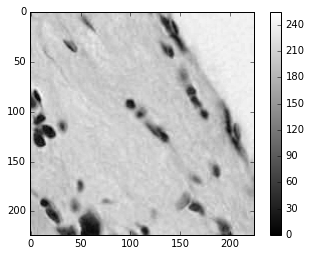

In [14]:
img_sat = patches_allClasses_sat['sp5'][np.random.randint(len(patches_allClasses_sat['sp5']))]
# img_sat = patches_allClasses_sat_concatenated[np.random.randint(patches_allClasses_sat_concatenated.shape[0])]
plt.imshow(img_sat, cmap=plt.cm.gray, vmin=0, vmax=255);
plt.colorbar();

In [ ]:
# patches_allClasses_sat_reshaped = dict([(l, patches[:,None,:,:] ) 
#                                         for l, patches in patches_allClasses_sat.iteritems()])

In [15]:
patches_allClasses_labels = []
patches_allClasses_concatenated = []

for l, patches in patches_allClasses_sat.iteritems():
    if l.endswith('surround'):
        label_ind = 0 # lump all surround into one BackG
    else:
        label_ind = labels_index[l]
    n = len(patches)
    patches_allClasses_labels.append(label_ind * np.ones((n,)))
    patches_allClasses_concatenated.append(patches)
    
patches_allClasses_labels = np.concatenate(patches_allClasses_labels)
patches_allClasses_concatenated = np.concatenate(patches_allClasses_concatenated)

# patches_allClasses_concatenated_reshaped = np.rollaxis(patches_allClasses_concatenated, 3, 1)
patches_allClasses_concatenated_reshaped = patches_allClasses_concatenated[:,None,:,:]

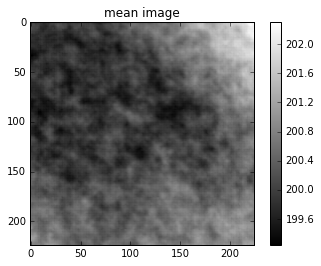

In [16]:
mean_img = np.concatenate(patches_allClasses_sat.values()).mean(axis=0)
np.save(model_dir + '/saturation_mean_224.npy', mean_img)

# mean_img = np.load(model_dir + '/saturation_mean_224.npy')

plt.imshow(mean_img, cmap=plt.cm.gray);
plt.title('mean image');
plt.colorbar();

In [17]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [18]:
# initial model

model_name = 'inception-stage1'
model_iteration = 10
init_model = mx.model.FeedForward.load(os.path.join(model_dir, model_name), 
                                     model_iteration, 
                                     ctx=mx.gpu())

arg_params = init_model.arg_params.copy()
arg_params.pop('fullc_bias');
arg_params.pop('fullc_weight');
arg_params['conv_1_weight'] = init_model.arg_params['conv_1_weight'].asnumpy()[:,[0],:,:]

n_class = len(labels)
flatten_output = init_model.symbol.get_internals()['flatten_output']
fc = mx.symbol.FullyConnected(data=flatten_output, name='fullc', num_hidden=n_class)
softmax = mx.symbol.SoftmaxOutput(data=fc, name='softmax')

In [ ]:
visualize_filters(init_model, 'conv_1_weight', input_channel=0, title='conv_1')
visualize_filters(init_model, 'conv_1_weight', input_channel=1, title='conv_1')
visualize_filters(init_model, 'conv_1_weight', input_channel=2, title='conv_1')
visualize_filters(init_model, 'conv_2_weight', input_channel=0)

In [19]:
n_epoch = 10
l_rate = 0.001
# checkpoint_prefix = os.path.join(model_dir, 'experiment0227')
checkpoint_prefix = os.path.join(model_dir, 'Sat16ClassFinetuned')

opt = mx.optimizer.SGD(learning_rate=l_rate)

net = mx.model.FeedForward(ctx=mx.gpu(), 
#                            symbol=init_model.symbol, 
                           symbol=softmax, 
                           num_epoch=n_epoch, optimizer=opt,
                           arg_params = arg_params, 
                           aux_params = init_model.aux_params,
                           allow_extra_params = True)

In [ ]:
# init_mean_img = mx.nd.load(os.path.join(model_dir, 'mean_224.nd'))['mean_img'].asnumpy()
# plt.imshow(init_mean_img[0], cmap=plt.cm.gray)
# plt.show()
# plt.imshow(init_mean_img[1], cmap=plt.cm.gray)
# plt.show()
# plt.imshow(init_mean_img[2], cmap=plt.cm.gray)
# plt.show()
# plt.imshow(mean_img, cmap=plt.cm.gray)
# plt.show()

In [20]:
patches_allClasses_normalized = patches_allClasses_concatenated_reshaped - mean_img

In [ ]:
batch_size = 96

train_iter = mx.io.NDArrayIter(
    patches_allClasses_normalized, 
    patches_allClasses_labels,
    batch_size = batch_size,
    shuffle=True
)

# eval_iter = mx.io.NDArrayIter(
#     patches_allClasses_eval_arr, 
#     patchLabels_allClasses_eval_arr,
#     batch_size = batch_size,
#     shuffle=True
# )

t = time.time()

# net.fit(train_iter, eval_data=eval_iter,
#         batch_end_callback=mx.callback.Speedometer(batch_size, 30),
#         epoch_end_callback=mx.callback.do_checkpoint(checkpoint_prefix))

net.fit(train_iter,
        batch_end_callback=mx.callback.Speedometer(batch_size, 30),
        epoch_end_callback=mx.callback.do_checkpoint(checkpoint_prefix))

net.save(checkpoint_prefix)

sys.stderr.write('training done in %f seconds\n' % (time.time() - t)) # ~ 18 seconds

# 100 samples/sec


INFO:root:Start training with [gpu(0)]
INFO:root:Epoch[0] Batch [30]	Speed: 118.14 samples/sec	Train-accuracy=0.622569
INFO:root:Epoch[0] Batch [60]	Speed: 112.53 samples/sec	Train-accuracy=0.670486
